<a href="https://colab.research.google.com/github/pinilDissanayaka/Tomato-Leaves-Disease-Classification/blob/main/Base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install livelossplot
!pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 10.5 MB/s eta 0:00:00


In [2]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [3]:
! kaggle datasets download cookiefinder/tomato-disease-multiple-sources

Dataset URL: https://www.kaggle.com/datasets/cookiefinder/tomato-disease-multiple-sources
License(s): CC0-1.0
100% 1.37G/1.37G [00:09<00:00, 190MB/s]
100% 1.37G/1.37G [00:09<00:00, 150MB/s]


In [4]:
! unzip /content/tomato-disease-multiple-sources.zip

Streaming output truncated to the last 5000 lines.
  inflating: valid/Late_blight/9afc2537-1b13-4c25-b5ed-5b8de511b0ab___GHLB2 Leaf 9033.JPG  
  inflating: valid/Late_blight/9bb49d22-976d-40c3-bc9a-bff5cbbd8e28___RS_Late.B 5057.JPG  
  inflating: valid/Late_blight/9c274db5-2f89-4f3c-b9e2-4d5ebc54ddad___GHLB2 Leaf 9096.JPG  
  inflating: valid/Late_blight/9c726f4e-045b-4080-b53d-d7e66d45bcb1___RS_Late.B 4876.JPG  
  inflating: valid/Late_blight/9e5dd34f-124c-4a64-ba9f-77c8d05faa9c___GHLB2 Leaf 8749.JPG  
  inflating: valid/Late_blight/9e633823-3dde-450c-8172-733021e4dff0___RS_Late.B 6414.JPG  
  inflating: valid/Late_blight/9ecb8001-2f48-4487-b287-535dbcfb5c2f___RS_Late.B 6206.JPG  
  inflating: valid/Late_blight/9f7dcd60-e691-4c1e-830e-7495f7cc123d___RS_Late.B 6166.JPG  
  inflating: valid/Late_blight/Bacterial_spots2276_jpg.rf.5becd3793ec2a532bf8f111d60911c63.jpg  
  inflating: valid/Late_blight/IMG_1526_jpg.rf.5e25005985e2b12a6f52bfa7120f3eee.jpg  
  inflating: valid/Late_blight/IMG_

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2 as cv
import os
import random
from glob import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAvgPool2D
from tensorflow.keras.applications import ResNet50, InceptionResNetV2
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
from livelossplot import PlotLossesKerasTF
import visualkeras
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight

import warnings
warnings.filterwarnings(action = 'ignore')

In [6]:
trainDir=f"/content/train"
validDir=f"/content/valid"

In [7]:
trainFolders=glob(os.path.join(trainDir, '*'))
outputSize=len(trainFolders)
trainingClassDic={}

print(f'Number of folders: {outputSize}\n')
for folder in trainFolders:
  print(f"class {os.path.basename(folder)}: {len(glob(os.path.join(folder, '*')))}")
  trainingClassDic[os.path.basename(folder)] = len(glob(os.path.join(folder, '*')))

Number of folders: 11

class Spider_mites Two-spotted_spider_mite: 1747
class Late_blight: 3113
class Early_blight: 2455
class Target_Spot: 1827
class powdery_mildew: 1004
class Tomato_Yellow_Leaf_Curl_Virus: 2039
class healthy: 3051
class Tomato_mosaic_virus: 2153
class Leaf_Mold: 2754
class Bacterial_spot: 2826
class Septoria_leaf_spot: 2882


In [8]:
validFolders=glob(os.path.join(validDir, '*'))
validOutputSize=len(validFolders)
validClassDic={}

print(f'Number of folders: {validOutputSize}\n')
for folder in validFolders:
  print(f"class {os.path.basename(folder)}: {len(glob(os.path.join(folder, '*')))}")
  validClassDic[os.path.basename(folder)] = len(glob(os.path.join(folder, '*')))

Number of folders: 11

class Spider_mites Two-spotted_spider_mite: 435
class Late_blight: 792
class Early_blight: 643
class Target_Spot: 457
class powdery_mildew: 252
class Tomato_Yellow_Leaf_Curl_Virus: 498
class healthy: 806
class Tomato_mosaic_virus: 584
class Leaf_Mold: 739
class Bacterial_spot: 732
class Septoria_leaf_spot: 746


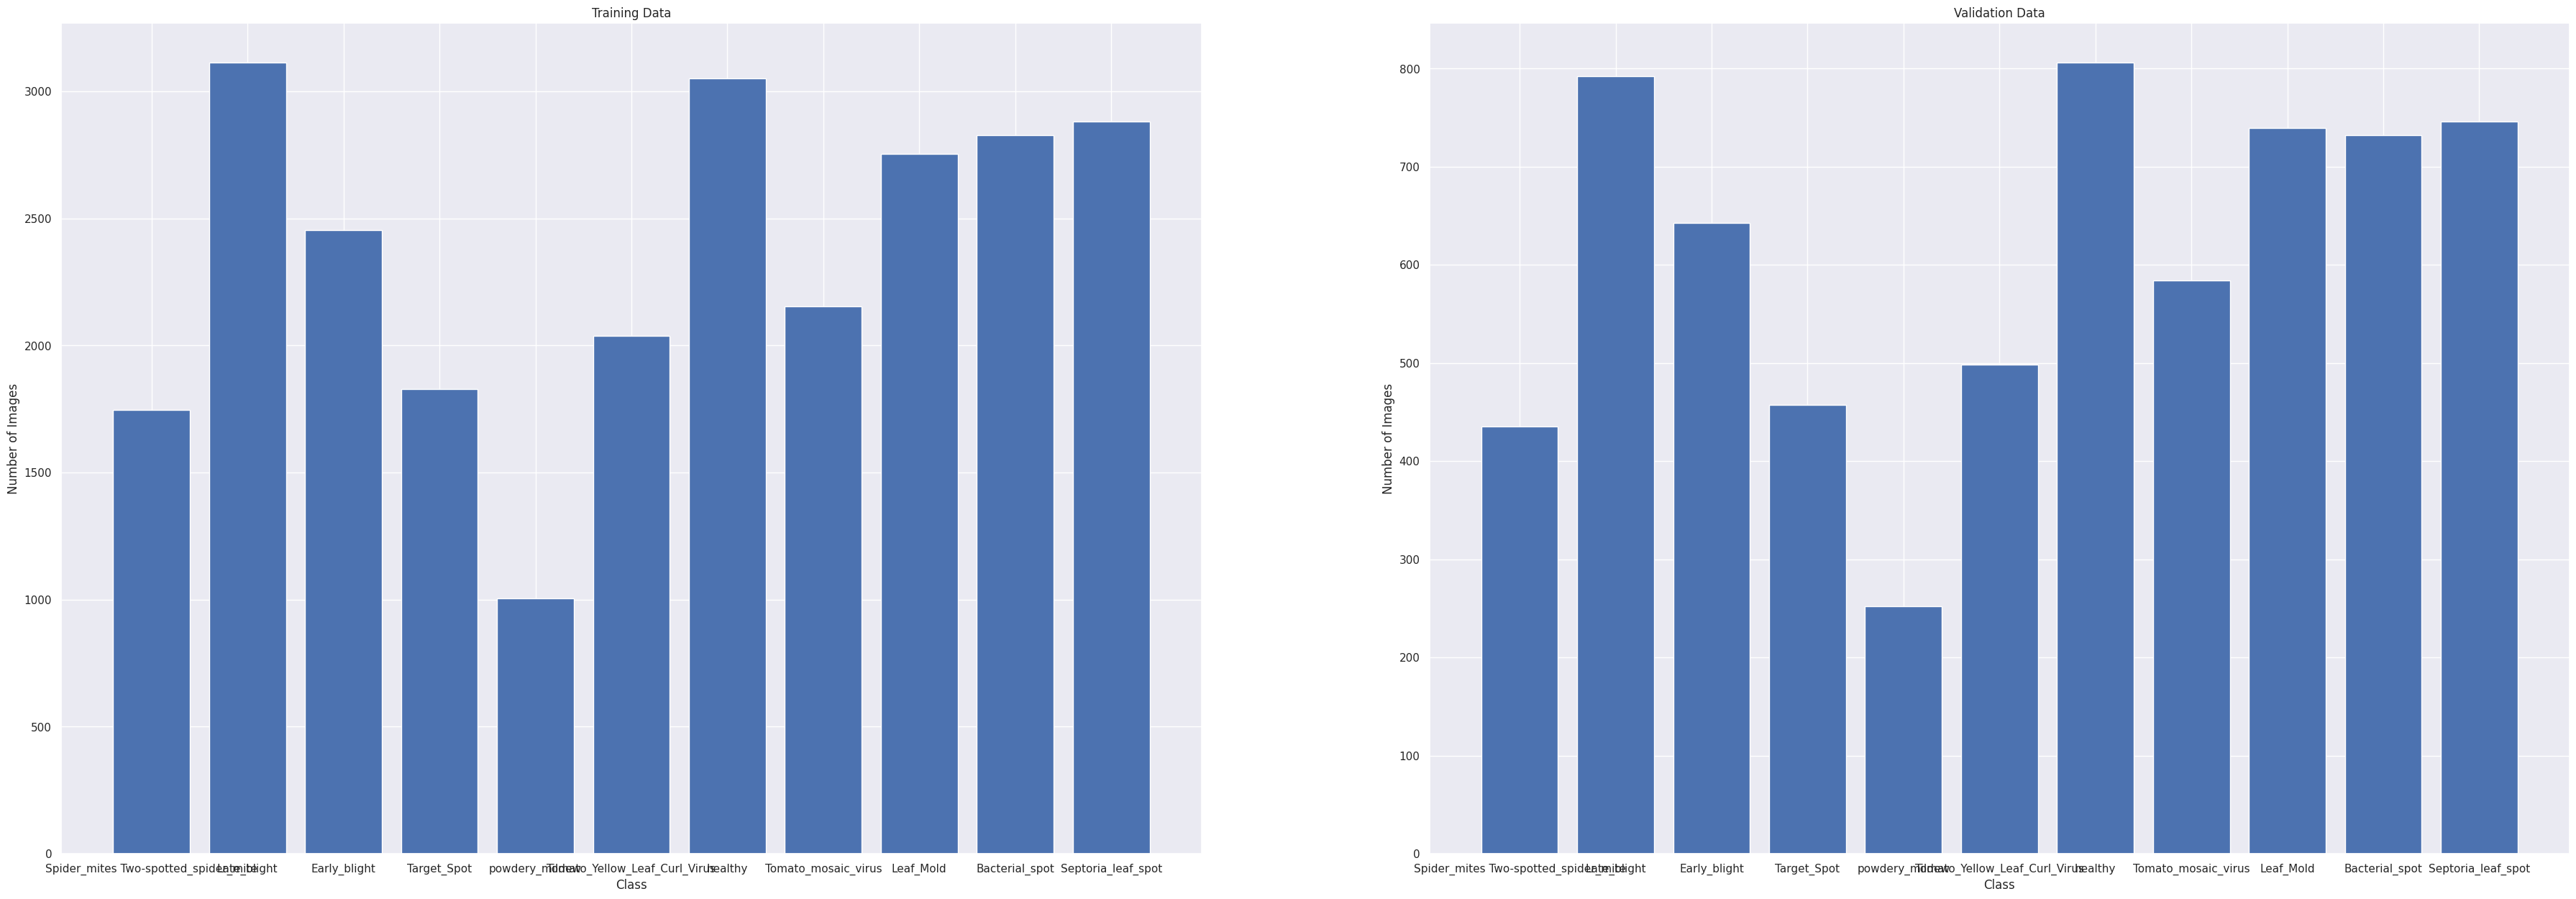

In [9]:
sns.set()
plt.figure(figsize=(45, 15))
plt.subplot(1, 2, 1)
plt.bar(x=list(trainingClassDic.keys()), height=list(trainingClassDic.values()))
plt.title('Training Data')
plt.ylabel('Number of Images')
plt.xlabel('Class')

plt.subplot(1, 2, 2)
plt.bar(x=list(validClassDic.keys()), height=list(validClassDic.values()))
plt.title('Validation Data')
plt.ylabel('Number of Images')
plt.xlabel('Class')
plt.show()

In [10]:
def printImages(trainFolders, ncol, nrow):
  for trainFolder in trainFolders:
    images=random.choices(glob(os.path.join(trainFolder, '*')), k=(ncol*nrow))
    plt.figure(figsize = (16, 16))
    for index, image in enumerate(images):
      image=plt.imread(image)
      plt.subplot(ncol, nrow, index+1)
      plt.xlabel(os.path.basename(os.path.basename(trainFolder)))
      plt.imshow(image)

In [ ]:
printImages(trainFolders=trainFolders, ncol=2, nrow=2)

In [11]:
def getImageSize(trainFolders):
  imageSize=set()
  for trainFolder in trainFolders:
    images=glob(os.path.join(trainFolder, '*'))
    for image in images:
      image=cv.imread(image)
      imageSize.add(image.shape)
  return imageSize



imageSize=getImageSize(trainFolders)
print(f'Image size: {imageSize}')


Image size: {(230, 750, 3), (800, 599, 3), (800, 733, 3), (800, 744, 3), (800, 493, 3), (511, 800, 3), (800, 482, 3), (480, 640, 3), (725, 966, 3), (800, 376, 3), (280, 347, 3), (3312, 4416, 3), (300, 205, 3), (800, 550, 3), (800, 561, 3), (800, 706, 3), (800, 684, 3), (800, 444, 3), (800, 433, 3), (800, 455, 3), (401, 534, 3), (150, 200, 3), (582, 800, 3), (459, 579, 3), (399, 442, 3), (800, 367, 3), (800, 512, 3), (800, 668, 3), (384, 550, 3), (1073, 1431, 3), (559, 750, 3), (800, 406, 3), (226, 296, 3), (1600, 1200, 3), (375, 250, 3), (913, 810, 3), (1024, 683, 3), (2285, 2400, 3), (800, 580, 3), (800, 725, 3), (800, 474, 3), (800, 463, 3), (400, 534, 3), (384, 512, 3), (2364, 3111, 3), (800, 368, 3), (1128, 1504, 3), (635, 500, 3), (1192, 1755, 3), (1066, 1153, 3), (800, 610, 3), (519, 550, 3), (424, 582, 3), (517, 640, 3), (800, 425, 3), (768, 1024, 3), (800, 436, 3), (336, 448, 3), (429, 506, 3), (540, 513, 3), (392, 600, 3), (800, 572, 3), (500, 667, 3), (795, 800, 3), (456, 600

In [36]:
def getImageExtension(folders):
  imageExtension=set()
  for folder in folders:
    images=glob(os.path.join(folder, '*'))
    for image in images:
      extension=os.path.splitext(image)[1]
      imageExtension.add(extension)
  return imageExtension

imageExtension=getImageExtension(trainFolders)
print(f'Image extension for training folder: {imageExtension}')

imageExtension=getImageExtension(validFolders)
print(f'Image extension for training folder: {imageExtension}')

Image extension for training folder: {'.png', '.jpeg', '.JPG', '.jpg'}
Image extension for training folder: {'.jpeg', '.jpg', '.JPG', '.png'}


In [33]:
targetSize = [225, 225]
inputSize = targetSize + [3]
batchSize = 32
rescale = 1./ 255
epochs = 100


trainDataGen = ImageDataGenerator(rescale=rescale,
                              horizontal_flip = True,
                              vertical_flip = True,
                              shear_range=16)

validDataGen = ImageDataGenerator(rescale=rescale)


trainGenerator = trainDataGen.flow_from_directory(trainDir,
                                              target_size=targetSize,
                                              class_mode='categorical',
                                              batch_size = batchSize,
                                              shuffle = True)

validGenerator = validDataGen.flow_from_directory(validDir,
                                              target_size=targetSize,
                                              class_mode='categorical',
                                              batch_size = batchSize)

Found 25851 images belonging to 11 classes.
Found 6684 images belonging to 11 classes.


In [17]:
stepsPerTrainingEpoch=trainGenerator.n // trainGenerator.batch_size
stepsPerValidationEpoch=validGenerator.n // validGenerator.batch_size

print(f"Every training epoch has {stepsPerTrainingEpoch} steps.")
print(f"Every validating epoch has {stepsPerValidationEpoch} steps.")

Every training epoch has 807 steps.
Every validating epoch has 208 steps.


In [18]:
classIndices=trainGenerator.class_indices
outputLabels={ index : label for label, index in classIndices.items()}


print(f"Class Indices : {classIndices}")
print(f"Output Labels : {outputLabels}")

Class Indices : {'Bacterial_spot': 0, 'Early_blight': 1, 'Late_blight': 2, 'Leaf_Mold': 3, 'Septoria_leaf_spot': 4, 'Spider_mites Two-spotted_spider_mite': 5, 'Target_Spot': 6, 'Tomato_Yellow_Leaf_Curl_Virus': 7, 'Tomato_mosaic_virus': 8, 'healthy': 9, 'powdery_mildew': 10}
Output Labels : {0: 'Bacterial_spot', 1: 'Early_blight', 2: 'Late_blight', 3: 'Leaf_Mold', 4: 'Septoria_leaf_spot', 5: 'Spider_mites Two-spotted_spider_mite', 6: 'Target_Spot', 7: 'Tomato_Yellow_Leaf_Curl_Virus', 8: 'Tomato_mosaic_virus', 9: 'healthy', 10: 'powdery_mildew'}


In [19]:
y = trainGenerator.classes

class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
class_weights = dict(enumerate(class_weights))
print(class_weights)

{0: 0.8315962169465354, 1: 0.9572671727457878, 2: 0.7549280144847123, 3: 0.853337294513765, 4: 0.8154375118289067, 5: 1.3452151740646303, 6: 1.2863113897596656, 7: 1.152570333050961, 8: 1.0915424566144492, 9: 0.7702690623044606, 10: 2.340727997102499}


In [20]:
earlyStopping = EarlyStopping(monitor='val_loss',
                              patience=2,
                              verbose=1)

reduceLr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.1,
                              patience=2,
                              min_lr=0.000001,
                              model='auto')

modelCheck = ModelCheckpoint("model_weights.h5",
                             monitor="val_accuracy",
                             save_weights_only=True,
                             mode="max",
                             verbose=1)


callBacks = [earlyStopping, reduceLr, modelCheck, PlotLossesKerasTF()]

In [28]:
def getCon(inputSize, outputSize):
  model = Sequential()

  model.add(Conv2D(16, (3, 3), activation='relu', padding="same", input_shape=inputSize))
  model.add(Conv2D(16, (3, 3), padding="same", activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.5))
  model.add(BatchNormalization())

  model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
  model.add(Conv2D(32, (3, 3), padding="same", activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.5))
  model.add(BatchNormalization())

  model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
  model.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.5))
  model.add(BatchNormalization())

  model.add(Conv2D(96, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
  model.add(Conv2D(96, (3, 3), padding="valid", activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.5))
  model.add(BatchNormalization())

  model.add(Conv2D(128, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
  model.add(Conv2D(128, (3, 3), padding="valid", activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.5))
  model.add(BatchNormalization())

  model.add(GlobalAvgPool2D())

  model.add(BatchNormalization())

  model.add(Dense(units = outputSize , activation='softmax'))

  model.summary()

  return model

In [29]:
modelV1=getCon(inputSize=inputSize, outputSize=outputSize)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 225, 225, 16)      448       
                                                                 
 conv2d_11 (Conv2D)          (None, 225, 225, 16)      2320      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 112, 112, 16)      0         
 g2D)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 112, 112, 16)      0         
                                                                 
 batch_normalization_6 (Bat  (None, 112, 112, 16)      64        
 chNormalization)                                                
                                                                 
 conv2d_12 (Conv2D)          (None, 112, 112, 32)     

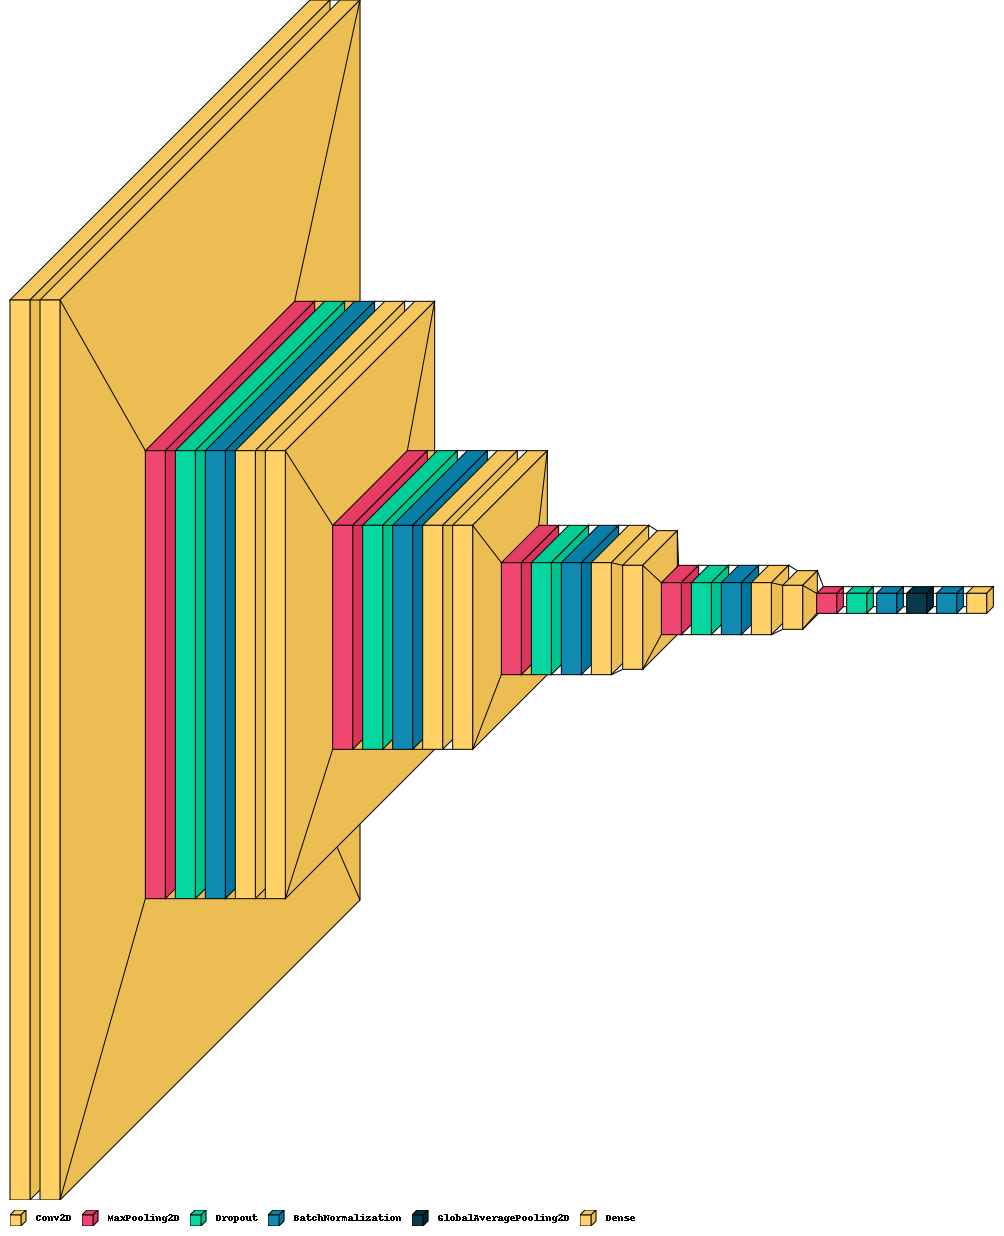

In [30]:
visualkeras.layered_view(modelV1, legend =True)

In [31]:
modelV1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
modelHistory = modelV1.fit_generator(trainGenerator,
                                steps_per_epoch=stepsPerTrainingEpoch,
                                epochs = 100,
                                verbose=1,
                                callbacks=callBacks,
                                validation_data=validGenerator,
                                validation_steps=stepsPerValidationEpoch,
                                workers=-1,
                                use_multiprocessing=True)

In [ ]:
def plotHistory(modeHistory):
  plt.figure(figsize=(12, 4))
  plt.subplot(1, 2, 1)
  plt.plot(modeHistory.history['loss'])
  plt.plot(modeHistory.history['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper right')

  plt.subplot(1, 2, 2)
  plt.plot(modeHistory.history['accuracy'])
  plt.plot(modeHistory.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='lower right')
  plt.show()

In [ ]:
plotHistory(modeHistory=modelHistory)